# Finding alternatives to DGLLife for Solubility prediction

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Using AqSolDB.

In [106]:
from tdc.single_pred import ADME
data = ADME(name = 'Solubility_AqSolDB')
split = data.get_split(frac=[0.8, 0.0, 0.2])

Found local copy...
Loading...
Done!


In [171]:
%%time
import numpy as np
from sklearn.preprocessing import normalize
from scikit_mol.descriptors import MolecularDescriptorTransformer

def calc_descriptors(mols):

    desc_list = [
        'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
        'HeavyAtomMolWt', 'MaxAbsPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
        'MinPartialCharge', 'MolWt', 'NumRadicalElectrons', 'NumValenceElectrons',
        'MolLogP', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
        'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
        'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
        'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount',
    ]

    transformer = MolecularDescriptorTransformer(desc_list, parallel=True)
    X = transformer.transform(mols)
    X = normalize(np.nan_to_num(X))
    
    return X

mols = [
    rdkit.Chem.MolFromSmiles(d)
    for d in split['train'].Drug
]
X_train = calc_descriptors(mols)
y_train = split['train']['Y']

CPU times: user 594 ms, sys: 244 ms, total: 838 ms
Wall time: 1.3 s


Train CatBoost.

In [118]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor()
cb.fit(X, y, verbose=False)

In [119]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

y_pred = cb.predict(X_train)
print('pearson R:', pearsonr(y_train, y_pred).statistic)
print('MAE:', mean_absolute_error(y_train, y_pred))

PearsonRResult(statistic=0.953489611791706, pvalue=0.0)

Now testing.

In [192]:
mols = split['test']['Drug'].apply(rdkit.Chem.MolFromSmiles)
X_test = calc_descriptors(mols)
y_test = split['test']['Y']
y_pred = cb.predict(X_test)

In [169]:
# cb.save_model('./', format='cbm')

Text(0.5, 1.0, 'Predicted vs. True log S | MAE = 0.747')

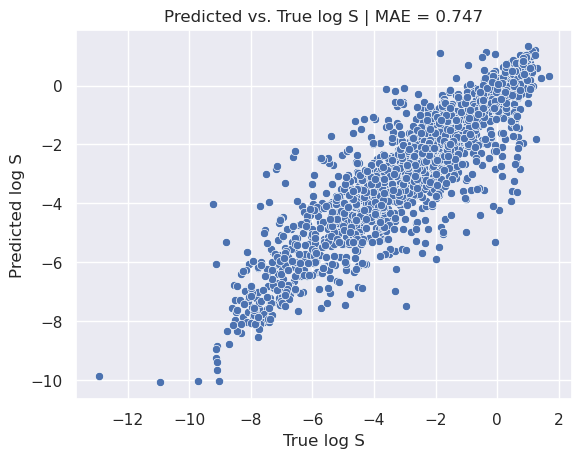

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('True log S')
plt.ylabel('Predicted log S')
plt.title('Predicted vs. True log S | MAE = 0.747')

In [149]:
import pandas as pd

pd.DataFrame(
    {'Descriptor': desc_list,
     'Importance': cb.feature_importances_}
).sort_values('Importance', ascending=False)

,Descriptor,Importance
12,MolLogP,25.505209
1,FpDensityMorgan1,14.603014
8,MinPartialCharge,5.069764
13,FractionCSP3,4.698611
2,FpDensityMorgan2,4.541416
5,MaxAbsPartialCharge,4.391848
7,MinAbsPartialCharge,3.625290
6,MaxAbsPartialCharge,3.307188
0,ExactMolWt,3.051014
4,HeavyAtomMolWt,2.876994


Now, testing on the DSI screening deck.

In [179]:
X_deck = calc_descriptors([d.mol for d in deck])
y_deck = deck.annotations['logS'].values

In [180]:
y_pred = cb.predict(X_deck)

Text(0.5, 1.0, 'Predicted vs. True log S | MAE = 0.747')

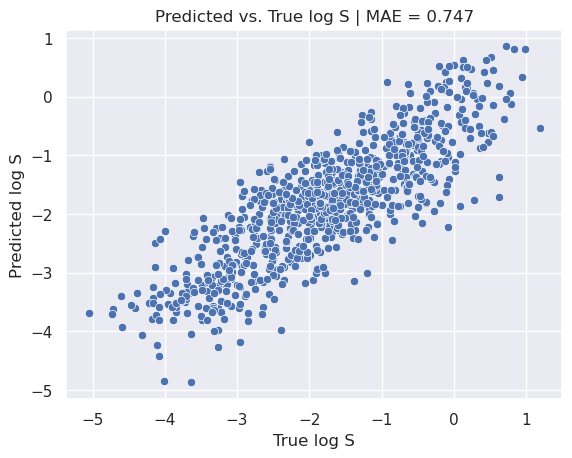

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.scatterplot(x=y_deck, y=y_pred)

mae = 
plt.xlabel('True log S')
plt.ylabel('Predicted log S')
plt.title('Predicted vs. True log S | MAE = 0.747')